In [9]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# ---------------------------------------------------------------------------
# Projektpfad setzen, damit "model" importierbar ist
# ---------------------------------------------------------------------------
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from model.simulation import (
    load_scenario,
    simulate_load_profile,
    load_vehicle_profiles_from_csv,  # falls du weiter oben die Flotte anschauen willst
)

In [10]:

# ---------------------------------------------------------------------------
# Szenario laden und Simulation durchführen
# ---------------------------------------------------------------------------
scenario_name = "highway"            # gewünschtes Szenario
scenario_path = f"../scenarios/{scenario_name}.yaml"

scenario = load_scenario(scenario_path)
timestamps, load_kw, sessions = simulate_load_profile(scenario)

In [11]:
# ---------------------------------------------------------------------------
# Kontrollen: Standorttyp, Zeitbereich und Simulationshorizont
# ---------------------------------------------------------------------------
print("Verwendetes Szenario:", scenario_name)
print(f"Erster Timestamp: {timestamps[0]}")
print(f"Letzter Timestamp: {timestamps[-1]}")
print(f"Simulationshorizont: {scenario['simulation_horizon_days']} Tage")

# ---------------------------------------------------------------------------
# Überblick: Anzahl Sessions und Beispiel-Sessions
# ---------------------------------------------------------------------------
print("\nAnzahl Ladesessions im Simulationshorizont:", len(sessions))
print("\nBeispiel-Sessions (erste 10):")

for s in sessions[:10]:
    print(
        f"Fahrzeug: {s['vehicle_name']}, "
        f"Ankunft: {s['arrival_time']}, "
        f"Abfahrt: {s['departure_time']}, "
        f"Kapazität: {s['battery_capacity_kwh']} kWh, "
        f"geladene Energie: {s['delivered_energy_kwh']:.1f} kWh, "      # NEU
        f"Restbedarf: {s['energy_required_kwh']:.1f} kWh"           # NEU
    )

# ---------------------------------------------------------------------------
# Auswertung: welche Fahrzeuge wurden wie oft geladen?
# ---------------------------------------------------------------------------
vehicle_names = [s["vehicle_name"] for s in sessions]
counts = Counter(vehicle_names)

print("\nVerwendete Fahrzeuge im Simulationshorizont:")
for model, n in counts.items():
    print(f"- {model}: {n} Sessions")

Verwendetes Szenario: highway
Erster Timestamp: 2025-05-19 00:00:00
Letzter Timestamp: 2025-06-10 23:00:00
Simulationshorizont: 23 Tage

Anzahl Ladesessions im Simulationshorizont: 886

Beispiel-Sessions (erste 10):
Fahrzeug: EQE SUV, Ankunft: 2025-05-19 12:26:03.595928, Abfahrt: 2025-05-19 12:47:27.362743, Kapazität: 91.0 kWh, geladene Energie: 0.0 kWh, Restbedarf: 77.7 kWh
Fahrzeug: #1, Ankunft: 2025-05-19 12:30:22.382145, Abfahrt: 2025-05-19 12:53:38.222419, Kapazität: 66.0 kWh, geladene Energie: 0.0 kWh, Restbedarf: 56.7 kWh
Fahrzeug: CLA, Ankunft: 2025-05-19 12:42:34.127511, Abfahrt: 2025-05-19 13:04:06.988451, Kapazität: 58.0 kWh, geladene Energie: 29.0 kWh, Restbedarf: 0.0 kWh
Fahrzeug: Taycan Tourismo, Ankunft: 2025-05-19 12:56:57.568421, Abfahrt: 2025-05-19 13:14:48.724041, Kapazität: 93.0 kWh, geladene Energie: 70.0 kWh, Restbedarf: 0.0 kWh
Fahrzeug: EQE, Ankunft: 2025-05-19 12:57:45.958744, Abfahrt: 2025-05-19 13:27:06.275205, Kapazität: 91.0 kWh, geladene Energie: 78.0 kWh,

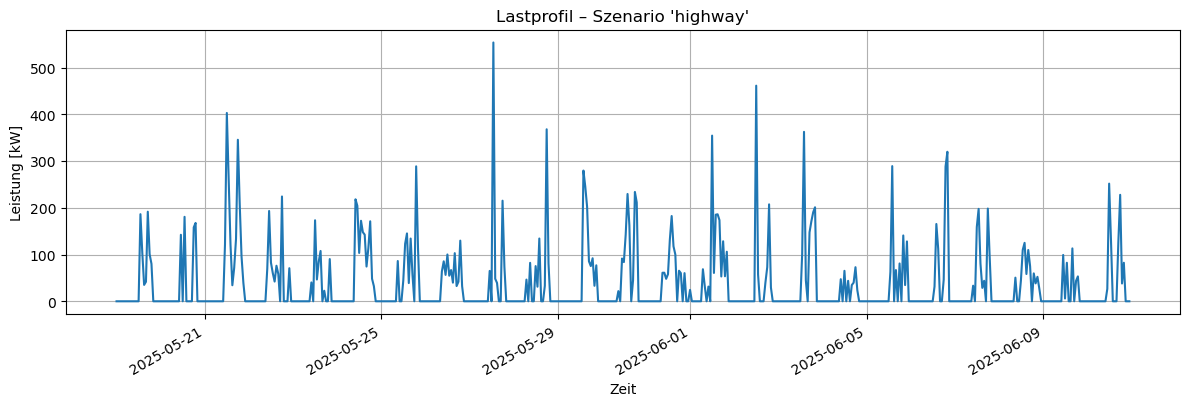

In [12]:
# ---------------------------------------------------------------------------
# 3) Lastprofil als Diagramm
# ---------------------------------------------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(timestamps, load_kw)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(f"Lastprofil – Szenario '{scenario_name}'")
plt.grid(True)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()
